<a href="https://colab.research.google.com/github/SpeedyBxi/email-classification/blob/main/independent_studies_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'spam-email-classification:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1522783%2F7263127%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240725%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240725T194525Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Dc4758376d00750922470eb2db728a011c5f1137a11abd9354dfa0a220bc18131fe008125e8e082ab6cec20716bf72c2d8b7549ddc53c5bd96183e6180a6e299967a5fcd7e02aa093903ffcb94be11ee8e5168891fcdde2d0f259efcb5730e003ebad59ac1ab629d92cd6f5df22f88e919e1b497d9ab54a0fefaf8f24e177a87be846a08ac26d2c63093e636e4aeee8e6546282e2941404aa4a922104928df2ed4565f6e524df5d5381992ccf40922d74d52b7e69842e31b5c4660a0c262ec3aaa9f9d1bf14146b5c73be919e1c54be2e2db98a22a39b185bfd5638bc3e866685abc0c738bba7b14c732e0deab2c3d711080bcee3b3117eb4153acb23c8cb43ac'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/spam-email-classification/email.csv


## Import all necessary libraries, pytorch, matplotlib for graphs, sklearn for TfidfVectorizer,

In [ ]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer

## Read the csv file, drop the last row since it didn't contain actual data, print columns and info to describe the data

In [ ]:
data = pd.read_csv("/kaggle/input/spam-email-classification/email.csv")
data = data.drop(data.index[-1])
print(data.columns)
print(data.info)

Index(['Category', 'Message'], dtype='object')
<bound method DataFrame.info of      Category                                            Message
0         ham  Go until jurong point, crazy.. Available only ...
1         ham                      Ok lar... Joking wif u oni...
2        spam  Free entry in 2 a wkly comp to win FA Cup fina...
3         ham  U dun say so early hor... U c already then say...
4         ham  Nah I don't think he goes to usf, he lives aro...
...       ...                                                ...
5567     spam  This is the 2nd time we have tried 2 contact u...
5568      ham               Will ü b going to esplanade fr home?
5569      ham  Pity, * was in mood for that. So...any other s...
5570      ham  The guy did some bitching but I acted like i'd...
5571      ham                         Rofl. Its true to its name

[5572 rows x 2 columns]>


## Plot the number of messages that were spam compared to the number that weren't spam

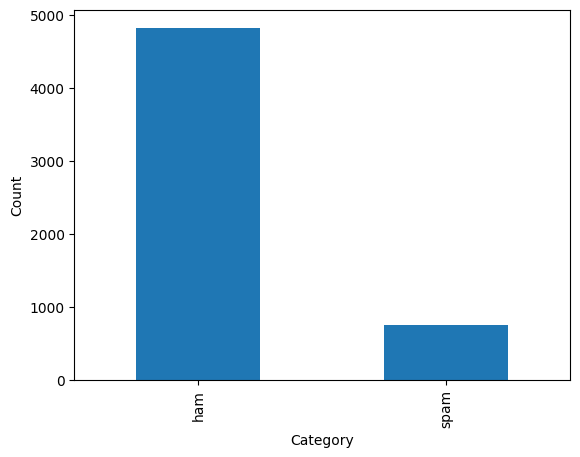

In [ ]:
data['Category'].value_counts().plot(kind='bar')
plt.xlabel('Category')
plt.ylabel('Count')
plt.show()

## Get the datatype of the data in order to know how to change it

In [ ]:
data.dtypes

Category    object
Message     object
dtype: object

## Change the emails that are spam to 1 and the emails that are not spam to 0

In [ ]:
data.loc[data['Category'] == 'ham', 'Category'] = 0

In [ ]:
data.loc[data['Category'] == 'spam', 'Category'] = 1

## Cast these numbers as integers for later

In [ ]:
data['Category'] = data['Category'].astype(int)

## Print first 10 rows of dataset in order to know what you're working with

In [ ]:
data.head(10)

,Category,Message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."
5,1,FreeMsg Hey there darling it's been 3 week's n...
6,0,Even my brother is not like to speak with me. ...
7,0,As per your request 'Melle Melle (Oru Minnamin...
8,1,WINNER!! As a valued network customer you have...
9,1,Had your mobile 11 months or more? U R entitle...


## Split the content and the category, the content will be trained and tested to make predictions and the category will be used to check those predictions

In [ ]:
X = data.Message
y = data.Category

## Print first 5 of the messages and categories of the data

In [ ]:
X.head(), y.head()

(0    Go until jurong point, crazy.. Available only ...
 1                        Ok lar... Joking wif u oni...
 2    Free entry in 2 a wkly comp to win FA Cup fina...
 3    U dun say so early hor... U c already then say...
 4    Nah I don't think he goes to usf, he lives aro...
 Name: Message, dtype: object,
 0    0
 1    0
 2    1
 3    0
 4    0
 Name: Category, dtype: int64)

## Split the data into testing and training data, 80% of the data will be used to train and 20% will be used to test

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2, #0.2 = 20% of data will be test and 80% will be train
                                                    random_state=42)
len(X_train), len(y_train), len(X_test), len(y_test)

(4457, 4457, 1115, 1115)

## Create a TfidfVectorizer with removes strings that aren't all letters, removes most common english words, only takes into account 300 words, the words are significant enough
transform and fit the training data, which evaluates the words in the data and assigns them numerical values

transform the testing data, which assigns the words values based on the previous documents

print first 10 words and values

In [ ]:
tfidf = TfidfVectorizer(token_pattern = '[a-z]+\w*', stop_words='english', max_features=300, max_df=0.5, min_df=5)
X_train = tfidf.fit_transform(X_train)
X_test = tfidf.transform(X_test)
print('\nidf values:')
i = 0
for ele1, ele2 in zip(tfidf.get_feature_names_out(), tfidf.idf_):
    print(ele1, ':', ele2)
    i += 1
    if i == 10:
        break
print("First 10 values")


idf values:
actually : 6.183579689077614
afternoon : 6.144358975924332
ah : 5.968468309460668
aight : 6.001258132283659
amp : 5.377103823210665
apply : 6.183579689077614
ask : 5.275321128900723
asked : 6.144358975924332
award : 6.458016534779373
awarded : 5.905947952479334
First 10 values


## Make sure the vectorized sparse matrices can be turned into arrays

In [ ]:
print(X_train.toarray())

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


### Idk why I did this tbh

In [ ]:
X.head(10)

0    Go until jurong point, crazy.. Available only ...
1                        Ok lar... Joking wif u oni...
2    Free entry in 2 a wkly comp to win FA Cup fina...
3    U dun say so early hor... U c already then say...
4    Nah I don't think he goes to usf, he lives aro...
5    FreeMsg Hey there darling it's been 3 week's n...
6    Even my brother is not like to speak with me. ...
7    As per your request 'Melle Melle (Oru Minnamin...
8    WINNER!! As a valued network customer you have...
9    Had your mobile 11 months or more? U R entitle...
Name: Message, dtype: object

In [ ]:
y.head(10)

0    0
1    0
2    1
3    0
4    0
5    1
6    0
7    0
8    1
9    1
Name: Category, dtype: int64

## Turn the training and testing data into tensors that we can actually use in our model, must be converted to array first
describe data

In [ ]:
X_train = torch.Tensor(X_train.toarray())
X_test = torch.Tensor(X_test.toarray())
X_train, X_test, X_train.size(), X_test.size()

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 torch.Size([4457, 300]),
 torch.Size([1115, 300]))

## Turn the categories into tensors as well, first have to convert from pandas Series to numpy arrays, then numpy arrays to tensors

In [ ]:
y_train = pd.Series.to_numpy(y_train)
y_test = pd.Series.to_numpy(y_test)
y_train = torch.Tensor(y_train)
y_test = torch.Tensor(y_test)
y_train, y_test

(tensor([1., 0., 0.,  ..., 0., 0., 0.]),
 tensor([0., 0., 0.,  ..., 0., 0., 0.]))

In [ ]:
y_train.size(), y_test.size()

(torch.Size([4457]), torch.Size([1115]))

## Make sure data types match for Messages and Categories

In [ ]:
X_test.dtype, y_test.dtype

(torch.float32, torch.float32)

## Create model with 2 layers, one with 300 features since that's the amount of features the tensors have from the vectorization, and a ReLU activation function for nonlinearity

In [ ]:
class SpamClassificationModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=300, out_features=200)
        self.layer_2 = nn.Linear(in_features=200, out_features=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.layer_2(self.relu(self.layer_1(x)))


## Instantiate model

In [ ]:
model = SpamClassificationModel()

## Make predictions with untrained model

In [ ]:
with torch.inference_mode():
    untrained_preds = model(X_test)
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(X_test)}, Shape: {X_test.shape}")
print(f"\nFirst 20 predictions:\n{torch.round(untrained_preds[:20])}")
print(f"\nFirst 20 labels:\n{y_test[:20]}")

Length of predictions: 1115, Shape: torch.Size([1115, 1])
Length of test samples: 1115, Shape: torch.Size([1115, 300])

First 20 predictions:
tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]])

First 20 labels:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0.])


### idek check data types again because I guess I forgot that I did that earlier

In [ ]:
X_test.dtype, y_test.dtype

(torch.float32, torch.float32)

## Create the loss function and optimizer, using binary cross entropy loss with logits and Adam

In [ ]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params=model.parameters(),
                            lr=0.01)

## Create accuracy function to determine accuracy of model

In [ ]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct/len(y_pred)) * 100
    return acc

## Training and testing loop!
torch.manual_seed to produce results that can be replicated

1000 epochs, yada yada yada sigmoid the logits and round them to get either ones or zeros

print out epochs, losses, and accuracies

In [ ]:
torch.manual_seed(24)
epochs = 1000
for epoch in range(epochs):
    model.train()

    y_logits = model(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    model.eval()
    with torch.inference_mode():
        test_logits = model(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_fn(test_logits,
                            y_test)
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)

    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f} Acc: {acc:.2f} &% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.70784 Acc: 13.55 &% | Test loss: 0.64921, Test acc: 90.94%
Epoch: 100 | Loss: 0.02077 Acc: 99.51 &% | Test loss: 0.11978, Test acc: 97.94%
Epoch: 200 | Loss: 0.01238 Acc: 99.62 &% | Test loss: 0.13866, Test acc: 97.76%
Epoch: 300 | Loss: 0.01121 Acc: 99.62 &% | Test loss: 0.15371, Test acc: 97.94%
Epoch: 400 | Loss: 0.01096 Acc: 99.62 &% | Test loss: 0.16318, Test acc: 97.94%
Epoch: 500 | Loss: 0.01087 Acc: 99.62 &% | Test loss: 0.16966, Test acc: 97.85%
Epoch: 600 | Loss: 0.01082 Acc: 99.62 &% | Test loss: 0.17458, Test acc: 97.94%
Epoch: 700 | Loss: 0.01080 Acc: 99.62 &% | Test loss: 0.17889, Test acc: 98.03%
Epoch: 800 | Loss: 0.01078 Acc: 99.62 &% | Test loss: 0.18256, Test acc: 98.03%
Epoch: 900 | Loss: 0.01077 Acc: 99.62 &% | Test loss: 0.18580, Test acc: 97.94%


### idk

In [ ]:
print(y_test.size())
print(test_pred.size())

torch.Size([1115])
torch.Size([1115])


## Test my my model on my own data and emails and print out the process so we can actually see that the model works

In [ ]:
def test_predictions(test_spam):
    model.eval()
    with torch.inference_mode():
        trained_test_pred = torch.round(torch.sigmoid(model(test_spam)))
    for i in range(len(trained_test_pred)):
        if trained_test_pred[i] == 1:
            print("Spam: \"" + test_df.iloc[i].Message + "\"")
        else:
            print("Not Spam: \"" + test_df.iloc[i].Message + "\"")
        print()

In [ ]:
test_data = [['Congratulations! You’ve won a $500 Amazon gift card. Claim it here', 1], ['Hey man, want to grab coffee and catch up sometime next week?', 0], ['FREE MONNEY NOW! Enter in this raffle TODAY for a chance to win $1,000,000!!!', 1], ['Hi Jacob! Ive attached a worksheet that we did in phsyics today. Let me know if you have any questions! Best, Hanan', 0], ['You Won an amazing offer! Guaranteed results within days! No upfront costs or investments required! Access to exclusive bonuses and discounts! Join thousands of satisfied customers who have already experienced life-changing results! But wait, theres more! Act now and receive a special discount of 100% off your first purchase! This limited-time offer wont last long, so dont miss out on this golden opportunity! To take advantage of this incredible offer, simply click on the link below or reply to this email with your contact information', 1], ['enter this raffle to win free money, aight. It good and I promise you will win just enter your credit card info to this link. www.link.com', 1], ["Dear [Recipient], Youve been personally selected for a special opportunity that's too good to ignore! For a brief window of time, you have the chance to seize a complimentary luxury vacation package to a destination of your choosing! Picture yourself basking in the sun on pristine beaches, enjoying fine dining, and immersing yourself in a world of relaxation—all at no cost to you! But that's not all. Alongside your dream vacation, youll also receive an automatic upgrade to our VIP membership, unlocking a treasure trove of exclusive perks and benefits that you won't find anywhere else! To secure your FREE vacation and unlock VIP access, simply click the link below and provide your details: [Claim Your FREE Vacation Now!]  Act fast! This offer is only available for a limited time, and slots are rapidly filling up! Dont let this chance for luxury slip away! Best Regards, [Your Name] Customer Experience Manager Luxury Travel Co.", 1], ["Dear Jacob, I hope this message finds you well. I'm reaching out to you with a heavy heart and a bit of vulnerability. As you know, I've encountered some unexpected financial challenges recently. Despite my best efforts to manage my finances responsibly, I find myself in a situation where I could really use some assistance. I wouldn't ask if I didn't truly need the help, and I wouldn't be coming to you if I didn't trust and value our friendship deeply. I'm reaching out to ask if you might be able to lend me some financial support during this difficult time. Whether it's a small loan or any amount you're comfortable with, it would mean the world to me and would go a long way in helping me get back on my feet. I understand that this is a big ask, and please know that I wouldn't expect anything without the intention of paying it back as soon as I am able. I'm committed to doing everything in my power to overcome this setback and to honor your generosity. If you're able to help, please let me know, and we can discuss the details further. If not, I completely understand, and I want you to know that your friendship and support mean more to me than anything. Thank you for taking the time to consider my request, and thank you, above all, for being the incredible friend that you are. With heartfelt gratitude, Marcus", 0]]
test_df = pd.DataFrame(test_data, columns=['Message', 'Category'])
print(test_df)
test_spam = test_df.Message
test_spam = tfidf.transform(test_spam)
test_spam = torch.Tensor(test_spam.toarray())

                                             Message  Category
0  Congratulations! You’ve won a $500 Amazon gift...         1
1  Hey man, want to grab coffee and catch up some...         0
2  FREE MONNEY NOW! Enter in this raffle TODAY fo...         1
3  Hi Jacob! Ive attached a worksheet that we did...         0
4  You Won an amazing offer! Guaranteed results w...         1
5  enter this raffle to win free money, aight. It...         1
6  Dear [Recipient], Youve been personally select...         1
7  Dear Jacob, I hope this message finds you well...         0


In [ ]:
test_predictions(test_spam)

Spam: "Congratulations! You’ve won a $500 Amazon gift card. Claim it here"

Not Spam: "Hey man, want to grab coffee and catch up sometime next week?"

Spam: "FREE MONNEY NOW! Enter in this raffle TODAY for a chance to win $1,000,000!!!"

Not Spam: "Hi Jacob! Ive attached a worksheet that we did in phsyics today. Let me know if you have any questions! Best, Hanan"

Spam: "You Won an amazing offer! Guaranteed results within days! No upfront costs or investments required! Access to exclusive bonuses and discounts! Join thousands of satisfied customers who have already experienced life-changing results! But wait, theres more! Act now and receive a special discount of 100% off your first purchase! This limited-time offer wont last long, so dont miss out on this golden opportunity! To take advantage of this incredible offer, simply click on the link below or reply to this email with your contact information"

Spam: "enter this raffle to win free money, aight. It good and I promise you will w